In [29]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib
import numpy as np



In [30]:
df=pd.read_csv("weather.csv")
print("Dimension de la Base: ",df.shape)
data_type=dict()
for i in range (0,30):
    data_type[df.columns[i]]=df[df.columns[i]].dtype
    
print("Types des données : ",data_type)
print("les valeurs manquantes : ")
print(df.isnull().sum())
print(df.describe())
print()


Dimension de la Base:  (119040, 31)
Types des données :  {'STA': dtype('int64'), 'Date': dtype('O'), 'Precip': dtype('O'), 'WindGustSpd': dtype('float64'), 'MaxTemp': dtype('float64'), 'MinTemp': dtype('float64'), 'MeanTemp': dtype('float64'), 'Snowfall': dtype('O'), 'PoorWeather': dtype('O'), 'YR': dtype('int64'), 'MO': dtype('int64'), 'DA': dtype('int64'), 'PRCP': dtype('O'), 'DR': dtype('float64'), 'SPD': dtype('float64'), 'MAX': dtype('float64'), 'MIN': dtype('float64'), 'MEA': dtype('float64'), 'SNF': dtype('O'), 'SND': dtype('float64'), 'FT': dtype('float64'), 'FB': dtype('float64'), 'FTI': dtype('float64'), 'ITH': dtype('float64'), 'PGT': dtype('float64'), 'TSHDSBRSGF': dtype('O'), 'SD3': dtype('float64'), 'RHX': dtype('float64'), 'RHN': dtype('float64'), 'RVG': dtype('float64')}
les valeurs manquantes : 
STA                 0
Date                0
Precip              0
WindGustSpd    118508
MaxTemp             0
MinTemp             0
MeanTemp            0
Snowfall         1163


C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_18384\3447635443.py:1: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("weather.csv")


Visualisation


=======features========
Index(['STA', 'Date', 'Precip', 'WindGustSpd', 'MaxTemp', 'MinTemp',
       'MeanTemp', 'Snowfall', 'PoorWeather', 'YR', 'MO', 'DA', 'PRCP', 'DR',
       'SPD', 'MAX', 'MIN', 'MEA', 'SNF', 'SND', 'FT', 'FB', 'FTI', 'ITH',
       'PGT', 'TSHDSBRSGF', 'SD3', 'RHX', 'RHN', 'RVG', 'WTE'],
      dtype='object')


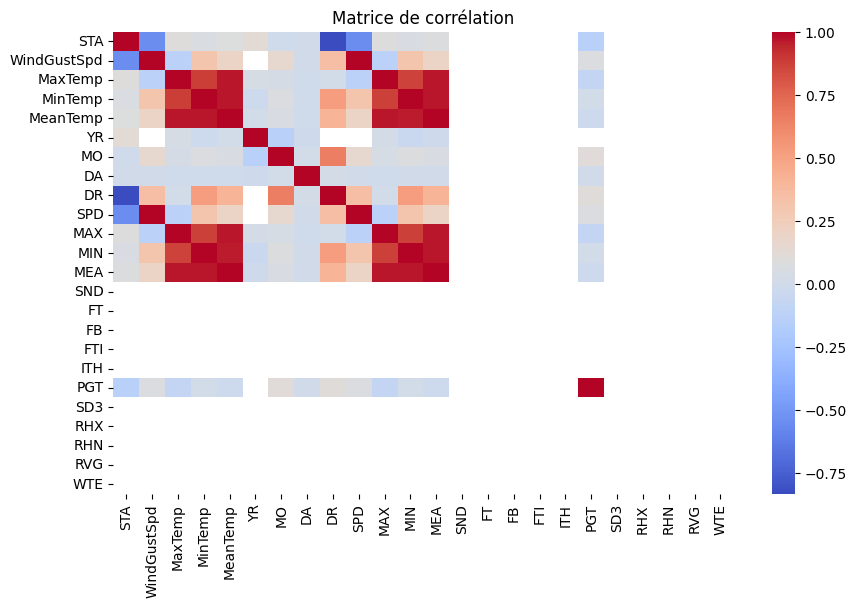

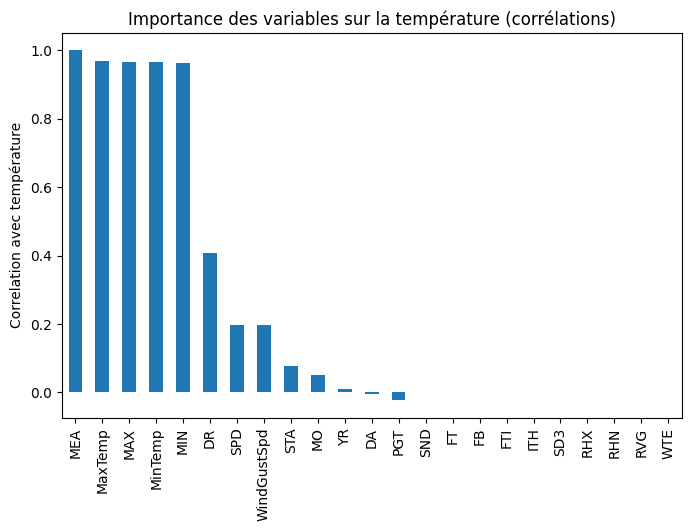

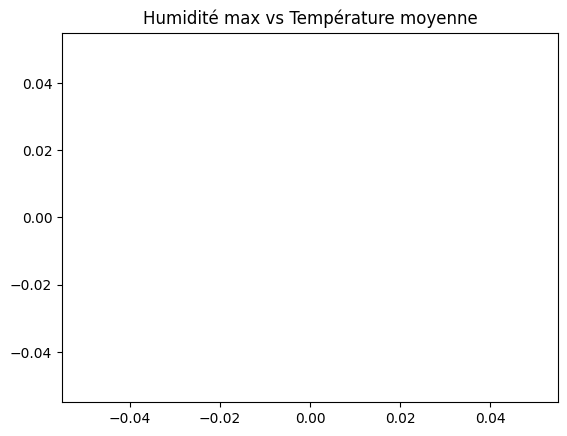

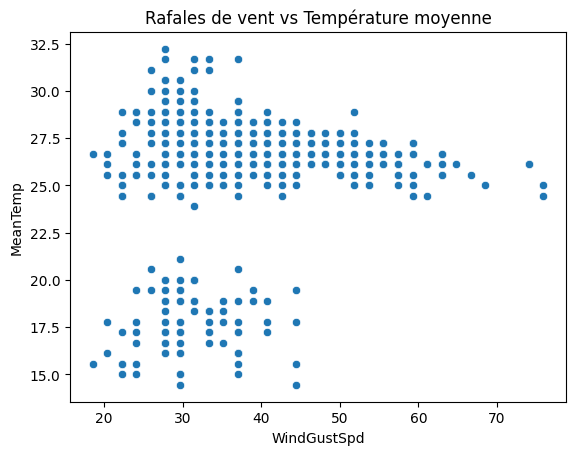

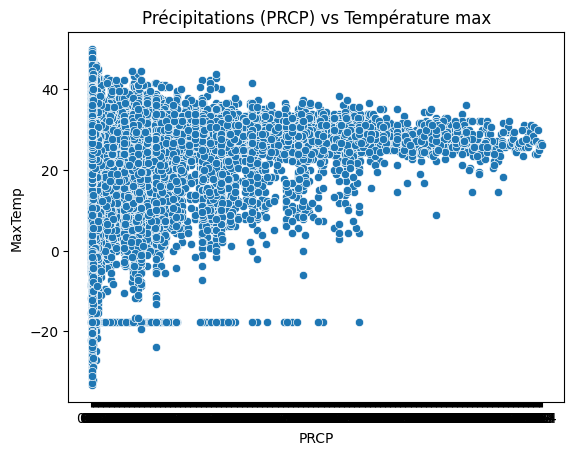

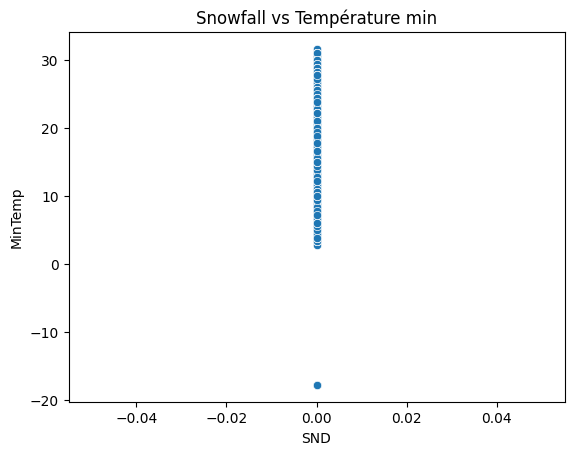

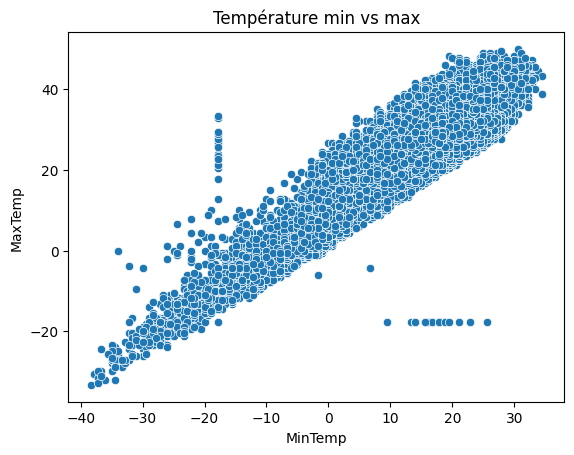

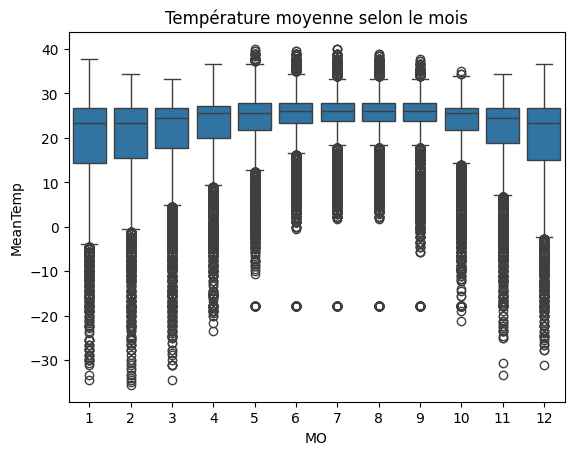

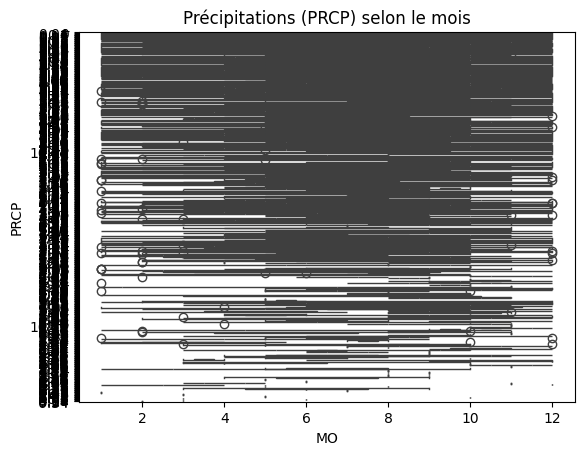

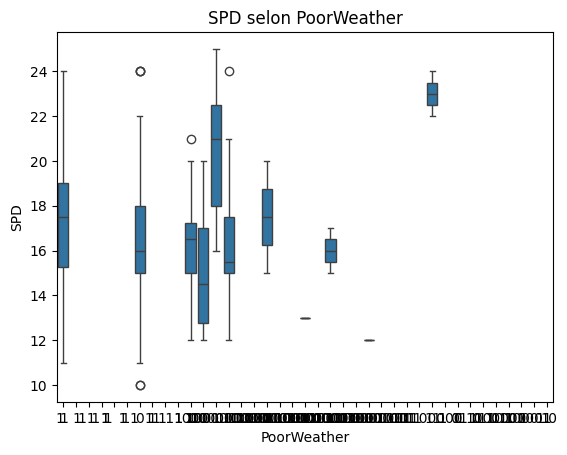

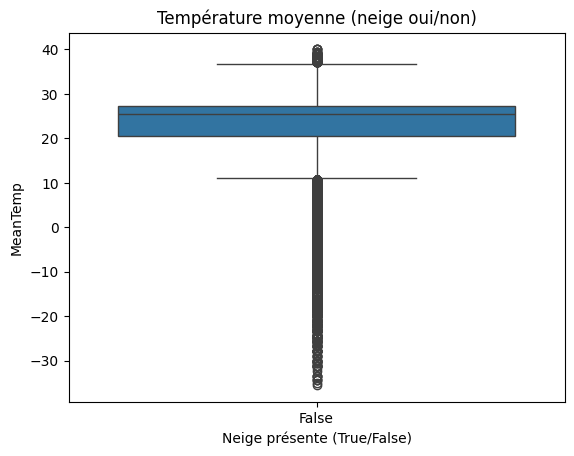

In [31]:
print("=======features========")
print(df.columns)
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()

corr_temp = df.corr(numeric_only=True)["MeanTemp"].sort_values(ascending=False)

plt.figure(figsize=(8,5))
corr_temp.drop("MeanTemp").plot(kind="bar")
plt.title("Importance des variables sur la température (corrélations)")
plt.ylabel("Correlation avec température")
plt.show()

# Humidité max vs Température moyenne
sns.scatterplot(df, x="RHX", y="MeanTemp")
plt.title("Humidité max vs Température moyenne")
plt.show()

# Rafales de vent vs Température moyenne
sns.scatterplot(df, x="WindGustSpd", y="MeanTemp")
plt.title("Rafales de vent vs Température moyenne")
plt.show()

# Précipitations vs Température max
sns.scatterplot(df, x="PRCP", y="MaxTemp")
plt.title("Précipitations (PRCP) vs Température max")
plt.show()

# Chute de neige vs Température min
sns.scatterplot(df, x="SND", y="MinTemp")
plt.title("Snowfall vs Température min")
plt.show()

# Température min vs max
sns.scatterplot(df, x="MinTemp", y="MaxTemp")
plt.title("Température min vs max")
plt.show()



# ---------- BOX PLOTS ----------

# Température moyenne par mois
sns.boxplot(df, x="MO", y="MeanTemp")
plt.title("Température moyenne selon le mois")
plt.show()

# Précipitations par mois
sns.boxplot(df, x="MO", y="PRCP")
plt.title("Précipitations (PRCP) selon le mois")
plt.show()

# Vitesse du vent selon PoorWeather
sns.boxplot(df, x="PoorWeather", y="SPD")
plt.title("SPD selon PoorWeather")
plt.show()

# Température moyenne selon présence de neige
sns.boxplot(df, x=(df["SND"] > 0), y="MeanTemp")
plt.title("Température moyenne (neige oui/non)")
plt.xlabel("Neige présente (True/False)")
plt.show()



PRETRAITEMENT

In [32]:

print("=======features========")
print(df.columns)
empty_cols = df.columns[df.isna().all()]
print("Empty columns:", list(empty_cols))
df.drop(empty_cols, axis=1, inplace=True)
print("=======features========")
print(df.columns)
colonne_a_supprimer = ['STA', 'Date','Precip','WindGustSpd', 'DR', 'SPD', 'SND','FT', 'FB', 'FTI', 'ITH', 'PGT',
 'SD3','RHX', 'RHN', 'RVG', 'WTE', 'TSHDSBRSGF','MAX', 'MIN', 'MEA','YR','DA','SNF','MaxTemp','Snowfall']
colonne_a_supprimer=list(set(colonne_a_supprimer)-set(empty_cols))
df.drop(colonne_a_supprimer, axis=1, inplace=True)
df = df.apply(pd.to_numeric, errors="coerce")
df = df.dropna()

y=df["MeanTemp"]
df.drop("MeanTemp", axis=1, inplace=True)
x=df
print("=======features restantes ========")
print(df.columns)
print(df.shape)



X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, "weather_scaler.pkl")
print(df.shape)







=======features========
Index(['STA', 'Date', 'Precip', 'WindGustSpd', 'MaxTemp', 'MinTemp',
       'MeanTemp', 'Snowfall', 'PoorWeather', 'YR', 'MO', 'DA', 'PRCP', 'DR',
       'SPD', 'MAX', 'MIN', 'MEA', 'SNF', 'SND', 'FT', 'FB', 'FTI', 'ITH',
       'PGT', 'TSHDSBRSGF', 'SD3', 'RHX', 'RHN', 'RVG', 'WTE'],
      dtype='object')
Empty columns: ['FT', 'FB', 'FTI', 'ITH', 'SD3', 'RHX', 'RHN', 'RVG', 'WTE']
=======features========
Index(['STA', 'Date', 'Precip', 'WindGustSpd', 'MaxTemp', 'MinTemp',
       'MeanTemp', 'Snowfall', 'PoorWeather', 'YR', 'MO', 'DA', 'PRCP', 'DR',
       'SPD', 'MAX', 'MIN', 'MEA', 'SNF', 'SND', 'PGT', 'TSHDSBRSGF'],
      dtype='object')
=======features restantes ========
Index(['MinTemp', 'PoorWeather', 'MO', 'PRCP'], dtype='object')
(23871, 4)
(23871, 4)


MODELISATION

In [33]:

LR = LinearRegression()
LR.fit(X_train_scaled, y_train)
y_pred = LR.predict(X_test_scaled)


DT = DecisionTreeRegressor(max_depth=5, random_state=42)
DT.fit(X_train_scaled, y_train)
y_pred_dt = DT.predict(X_test_scaled)




EVALUATION 


===== COMPARAISON DES MODÈLES =====
                         RMSE       MSE       MAE        R2
Régression Linéaire  1.716695  2.947042  1.166792  0.951089
Arbre de Décision    1.604278  2.573708  1.061473  0.957285


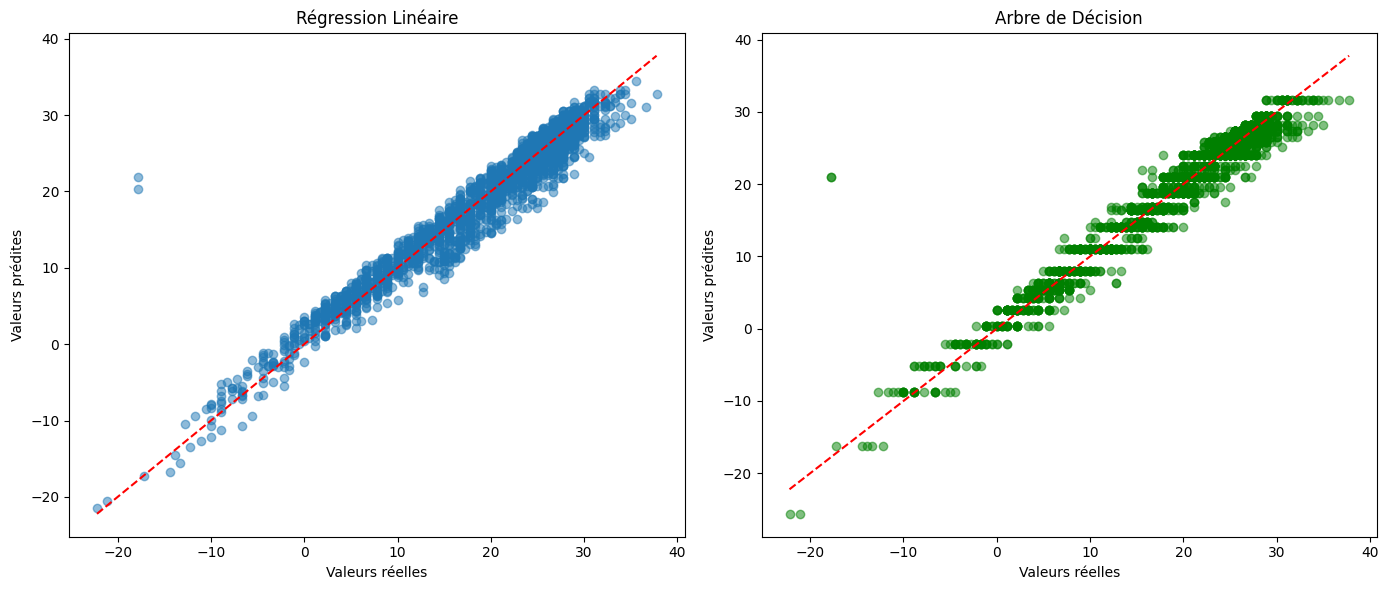


===== Importance des variables (Arbre de Décision) =====
       Feature  Importance
0      MinTemp    0.993249
3         PRCP    0.006424
2           MO    0.000326
1  PoorWeather    0.000000

===== Coefficients (Régression Linéaire) =====
       Feature  Coefficient
0      MinTemp     7.671757
1  PoorWeather     0.107207
2           MO    -0.067994
3         PRCP    -0.218581


In [34]:


results = pd.DataFrame({
    "RMSE": [np.sqrt(mean_squared_error(y_test, y_pred)),
             np.sqrt(mean_squared_error(y_test, y_pred_dt))],
    "MSE": [mean_squared_error(y_test, y_pred),
            mean_squared_error(y_test, y_pred_dt)],
    "MAE": [mean_absolute_error(y_test, y_pred),
            mean_absolute_error(y_test, y_pred_dt)],
    "R2":  [r2_score(y_test, y_pred),
            r2_score(y_test, y_pred_dt)]
},
index=["Régression Linéaire", "Arbre de Décision"])

print("\n===== COMPARAISON DES MODÈLES =====")
print(results)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Linear Regression plot ---
axes[0].scatter(y_test, y_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_title("Régression Linéaire")
axes[0].set_xlabel("Valeurs réelles")
axes[0].set_ylabel("Valeurs prédites")

# --- Decision Tree plot ---
axes[1].scatter(y_test, y_pred_dt, alpha=0.5, color="green")
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1].set_title("Arbre de Décision")
axes[1].set_xlabel("Valeurs réelles")
axes[1].set_ylabel("Valeurs prédites")

plt.tight_layout()
plt.show()


importance_dt = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": DT.feature_importances_
}).sort_values("Importance", ascending=False)

print("\n===== Importance des variables (Arbre de Décision) =====")
print(importance_dt)

coef_lr = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": LR.coef_
}).sort_values("Coefficient", ascending=False)

print("\n===== Coefficients (Régression Linéaire) =====")
print(coef_lr)

